In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import tqdm
import scipy

In [2]:
# set random seed for debugging purpose, need to turn off when perform monte carlo
# np.random.seed(42)

In [3]:
# plots
def gain(w):
    """Return the power as a function of azimuthal angle, phi."""
    phi = np.linspace(0, 2*np.pi, 1000)
    psi = 2*np.pi * 1 / 2 * np.cos(phi)
    j = np.arange(len(w))
    A = np.sum(w[j] * np.exp(j * 1j * psi[:, None]), axis=1)
    g = np.abs(A)**2
    return phi, g

def get_directive_gain(g, minDdBi=-20):
    """Return the "directive gain" of the antenna array producing gain g."""
    DdBi = 10 * np.log10(g / np.max(g))
    return np.clip(DdBi, minDdBi, None)

## channel generation

In [4]:
def rand_angles(M):
    return np.random.randint(0, 180, M)/180*np.pi # 0->180deg

def rand_distances(M):
    return np.random.randint(1000, 2500, M) # 50-250m

def get_path_loss_phase_diff(angles, distances, N, M):
    r = np.arange(N)
    return np.array([lambda_/(4*np.pi*distances[i])*np.exp(-1j*2*(np.pi*r/2)*np.cos(angles[i])).reshape((N, 1)) for i in range(M)]) # with path loss
    # return np.array([np.exp(-1j*2*(np.pi*r/2)*np.cos(angles[i])).reshape((N, 1)) for i in range(M)]) # no path loss

def generate_channels_LOS(angles, distances, N, M, rho_min_qos_sigma2=1, sigma_i=1):
    r = np.arange(N)
    h_array_LOS = [lambda_/(4*np.pi*distances[i])*np.exp(-1j*2*(np.pi*r/2)*np.cos(angles[i])).reshape((N, 1)) for i in range(M)]
    h_array_LOS_norm_QoS = []
    h_array_LOS_norm_MaxMin = []
    
    for i in range(M):
        # normalization QoS
        h_i_norm_QoS = h_array_LOS[i]/np.sqrt(rho_min_qos_sigma2)
        h_array_LOS_norm_QoS.append(h_i_norm_QoS)

        # normalization MaxMin
        h_i_norm_MaxMin = h_array_LOS[i]/sigma_i
        h_array_LOS_norm_MaxMin.append(h_i_norm_MaxMin)
    
    # generate H_i matrix
    H_array_LOS = []
    H_array_LOS_norm_QoS = []
    H_array_LOS_norm_MaxMin = []
    for i in range(M):
        H_array_LOS.append(np.matmul(h_array_LOS[i], np.conjugate(h_array_LOS[i]).T))
        H_array_LOS_norm_QoS.append(np.matmul(h_array_LOS_norm_QoS[i], np.conjugate(h_array_LOS_norm_QoS[i]).T))
        H_array_LOS_norm_MaxMin.append(np.matmul(h_array_LOS_norm_MaxMin[i], np.conjugate(h_array_LOS_norm_MaxMin[i]).T))
        
    return h_array_LOS, h_array_LOS_norm_QoS, h_array_LOS_norm_MaxMin, H_array_LOS, H_array_LOS_norm_QoS, H_array_LOS_norm_MaxMin
        
def generate_channels(N, M, pl=None, rho_min_qos_sigma2=1, sigma_i=1):
    # channel generation
    h_array = []
    h_array_norm_QoS = []
    h_array_norm_MaxMin = []
    for i in range(M):
        # complex normal with zero-mean, unit-variance
        # h_i = np.random.normal(loc=0, scale=np.sqrt(2)/2, size=(N, 2)).view(np.complex128)
        if pl is not None:
            # path loss model & phase delay for multiple transmit antenna
            h_i = np.sqrt(2)/2*(np.random.randn() + 1j*np.random.randn())*pl[i]
        else:
            h_i = np.sqrt(2)/2*(np.random.randn(N) + 1j*np.random.randn(N)).reshape((N, 1))
        h_array.append(h_i)

        # normalization QoS
        h_i_norm_QoS = h_i/np.sqrt(rho_min_qos_sigma2)
        h_array_norm_QoS.append(h_i_norm_QoS)

        # normalization MaxMin
        h_i_norm_MaxMin = h_i/sigma_i
        h_array_norm_MaxMin.append(h_i_norm_MaxMin)

    # generate H_i matrix
    H_array = []
    H_array_norm_QoS = []
    H_array_norm_MaxMin = []
    for i in range(M):
        H_array.append(np.matmul(h_array[i], np.conjugate(h_array[i]).T))
        H_array_norm_QoS.append(np.matmul(h_array_norm_QoS[i], np.conjugate(h_array_norm_QoS[i]).T))
        H_array_norm_MaxMin.append(np.matmul(h_array_norm_MaxMin[i], np.conjugate(h_array_norm_MaxMin[i]).T))
        
    return h_array, h_array_norm_QoS, h_array_norm_MaxMin, H_array, H_array_norm_QoS, H_array_norm_MaxMin
    

## Randomization

In [5]:
def recover_w_SVD(W_opt):
    v, d = np.linalg.eig(W_opt)
    w_opt = d[:,0]
    return w_opt.reshape((W_opt.shape[0], 1))

def recover_w_randA(W_opt):
    v, d = np.linalg.eig(W_opt)
    # rand e
    e_js = np.random.uniform(0, 2*np.pi, W_opt.shape[0]).reshape((W_opt.shape[0], 1))
    e = np.cos(e_js) + 1j*np.sin(e_js)
    
    Sigma_sqrt = np.sqrt(np.diag(v))
    w_opt = np.matmul(np.matmul(d, Sigma_sqrt), e)
    return w_opt.reshape((W_opt.shape[0], 1))

def recover_w_randB(W_opt):
    e_js = np.random.uniform(0, 2*np.pi, W_opt.shape[0]).reshape((W_opt.shape[0], 1))
    e = np.cos(e_js) + 1j*np.sin(e_js)
    w_opt = np.matmul(np.sqrt(np.diag(np.diag(W_opt))), e)
    return w_opt.reshape((W_opt.shape[0], 1))
    
def recover_w_randC(W_opt):
    v, d = np.linalg.eig(W_opt)
    # rand e
    e_js = np.random.normal(loc=0, scale=np.sqrt(2)/2, size=(W_opt.shape[0], 2)).view(np.complex128)
    e = np.cos(e_js) + 1j*np.sin(e_js)
    
    Sigma_sqrt = np.sqrt(np.diag(v))
    w_opt = np.matmul(np.matmul(d, Sigma_sqrt), e)
    return w_opt.reshape((W_opt.shape[0], 1))
    

## Check violation

In [339]:
def check_violation(w, h):
    scale_factor = 1
    constraint = np.abs(np.dot(np.conjugate(h).T, w))[0][0]**2
    # print(constraint)
    violate = constraint < 1
    if violate:
        return np.sqrt(1.0/constraint), constraint
    return scale_factor, constraint

def get_min_scale_factor(w, h_list):
    scale_factor = -np.inf
    for i in range(len(h_list)):
        s, _ = check_violation(w, h_list[i])
        scale_factor = np.max([scale_factor, s])
    return scale_factor

def calc_norm2(w):
    # return np.sqrt(np.abs(np.dot(np.conjugate(w).T, w))[0][0])
    return np.linalg.norm(w)

In [310]:
get_min_scale_factor(w_randA, h_array_norm_QoS)

1.0

In [338]:
np.abs(1+1j)

1.4142135623730951

In [343]:
N = 4 # number of transmit antennas
M = 8 # number of mobile users
# P = 1 # transmit power

lambda_ = 0.375 # carrier wavelength
antenna_sep = 1/2 # antenanna separation half wavelength

# QoS
rho_min_qos_sigma2 = 1 #rho_min_i * sigma_i^2 = 1 for all i

# Max-Min
sigma_i = 1 

In [344]:
angles = rand_angles(M)
distances = rand_distances(M)

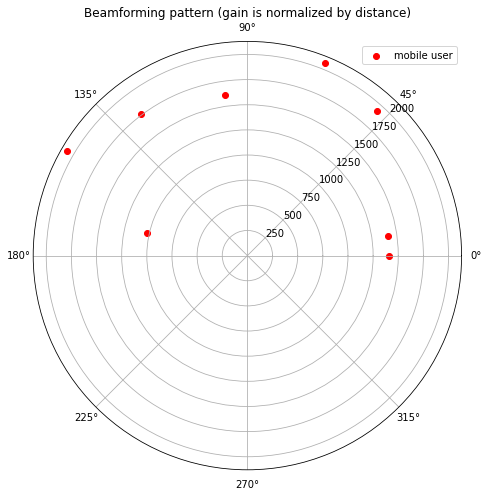

In [345]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='polar')
ax.scatter(angles, distances, color="red", label="mobile user")
# ax.set_rticks([0, 50, 100, 200, 250])
ax.set_rlabel_position(45)
plt.title("Beamforming pattern (gain is normalized by distance)")
plt.legend()
plt.tight_layout()
plt.show()

## Generate LoS channel

In [312]:
h_array, h_array_norm_QoS, h_array_norm_MaxMin, H_array, H_array_norm_QoS, H_array_norm_MaxMin = generate_channels_LOS(angles, distances, N, M, rho_min_qos_sigma2=1, sigma_i=1)

## QoS LoS sanity check

In [313]:
W = cp.Variable((N, N), hermitian=True)

# need to use cp.real since cp.trace will give imaginary part = 0j, which will break the code
constraints = [W >> 0]
constraints += [cp.real(cp.trace(cp.matmul(W, H_array_norm_QoS[i]))) >= 1 for i in range(M)]

prob = cp.Problem(cp.Minimize( cp.real(cp.trace(W))),
             constraints)
opt = prob.solve(solver="MOSEK", verbose=False)
W_opt = W.value

print("optimal objective value = ", opt)
# print("optimal beamforming vector = ", W_opt)

# recover svd
w_SVD   = recover_w_SVD(W_opt)
scale_factor_SVD = get_min_scale_factor(w_SVD, H_array_norm_QoS)
w_SVD *= scale_factor_SVD
ubpb_SVD = np.linalg.norm(w_SVD)**2/opt
print("SVD upper bound power boost (dB) = ", ubpb_SVD)
ubpb = []

for i in range(1000):
    # recover randomization
    w_randA = recover_w_randA(W_opt)
    w_randB = recover_w_randB(W_opt)
    w_randC = recover_w_randC(W_opt)

    scale_factor_randA = get_min_scale_factor(w_randA, h_array_norm_QoS)
    scale_factor_randB = get_min_scale_factor(w_randB, h_array_norm_QoS)
    scale_factor_randC = get_min_scale_factor(w_randC, h_array_norm_QoS)

    w_randA *= scale_factor_randA
    w_randB *= scale_factor_randB
    w_randC *= scale_factor_randC
    
    w_l = [w_SVD, w_randA, w_randB, w_randC]
    norm_l = [calc_norm2(w_SVD), calc_norm2(w_randA), calc_norm2(w_randB), calc_norm2(w_randC)]

    w_min = w_l[np.argmin(norm_l)]
    ubpb.append(calc_norm2(w_min)/opt)
    
print("MC 1000 upper bound power boost (dB) = ", np.min(ubpb), "mean = ", np.mean(ubpb), "std = ", np.std(ubpb))

w_best = None
ubpb_best = np.inf

for i in range(30*N*M):
# for i in range(10000):
    # recover randomization
    w_randA = recover_w_randA(W_opt)
    w_randB = recover_w_randB(W_opt)
    w_randC = recover_w_randC(W_opt)

    scale_factor_randA = get_min_scale_factor(w_randA, h_array_norm_QoS)
    scale_factor_randB = get_min_scale_factor(w_randB, h_array_norm_QoS)
    scale_factor_randC = get_min_scale_factor(w_randC, h_array_norm_QoS)

    w_randA *= scale_factor_randA
    w_randB *= scale_factor_randB
    w_randC *= scale_factor_randC
    
    w_l = [w_SVD, w_randA, w_randB, w_randC]
    norm_l = [calc_norm2(w_SVD), calc_norm2(w_randA), calc_norm2(w_randB), calc_norm2(w_randC)]

    w_min = w_l[np.argmin(norm_l)]
    ubpb.append(calc_norm2(w_min)/opt)
    
    if ubpb[-1] < ubpb_best:
        w_best = w_min
        ubpb_best = ubpb[-1]
w_best_qos = w_best
print("MC 30*N*M=", 30*N*M, "upper bound power (dB) boost = ", np.min(ubpb), "mean = ", np.mean(ubpb), "std = ", np.std(ubpb))

optimal objective value =  2458293988.1308413
SVD upper bound power boost (dB) =  4.332119382210803e+17
MC 1000 upper bound power boost (dB) =  2.110120099668072e-05 mean =  3.25350176172257e-05 std =  9.998423381272386e-06
MC 30*N*M= 960 upper bound power (dB) boost =  2.078936873774533e-05 mean =  3.2646048348889764e-05 std =  1.0891847105325721e-05


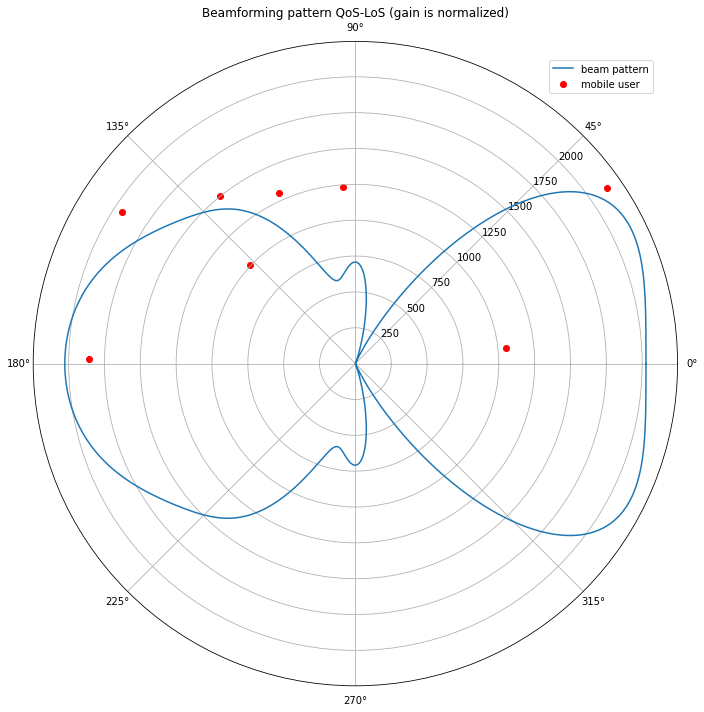

In [314]:
w = w_best_qos.ravel()
# Calculate gain and directive gain; plot on a polar chart.
phi, g = gain(w)
DdBi = get_directive_gain(g)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='polar', label="meters")
ax.plot(phi, g*np.max(distances)/np.max(g), label="beam pattern")
# ax.plot(phi, np.max(distances)*np.log10(g)/np.log10(np.max(g)), label="beam pattern")
ax.scatter(angles, distances, color="red", label="mobile user")
# ax.set_rticks([0, 50, 100, 200, 250])
ax.set_rlabel_position(45)
plt.title("Beamforming pattern QoS-LoS (gain is normalized)")
plt.legend()
ax.legend(loc=(0.8,0.92))
plt.tight_layout()

plt.show()

In [178]:
# fig.savefig("fig2_qos_los_4user_32an.png")

## MaxMin LoS sanity check

In [279]:
W = cp.Variable((N, N), hermitian=True)
t = cp.Variable(1)

constraints = [W >> 0]
constraints += [cp.real(cp.trace(W)) == 1] # power constraint
constraints += [cp.real(cp.trace(cp.matmul(W, H_array_norm_MaxMin[i]))) >= t for i in range(M)]

prob = cp.Problem(cp.Maximize(t),
             constraints)
opt = prob.solve(solver="MOSEK", verbose=False)
W_opt = W.value

print("optimal objective value = ", opt)
# print("optimal beamforming vector = ", W_opt)

w_best_maxmin = None
scal_min = np.inf
for i in tqdm.tqdm(range(30*N*M)):
    # recover randomization
    w_randA = recover_w_randA(W_opt)
    w_randB = recover_w_randB(W_opt)
    w_randC = recover_w_randC(W_opt)

    scale_factor_randA = calc_norm2(w_randA)
    scale_factor_randB = calc_norm2(w_randB)
    scale_factor_randC = calc_norm2(w_randC)

    w_randA /= scale_factor_randA
    w_randB /= scale_factor_randB
    w_randC /= scale_factor_randC

    w_l = [w_randA, w_randB, w_randC]
    scal = [scale_factor_randA, scale_factor_randB, scale_factor_randC]

    w_best_tmp = w_l[np.argmin(scal)]
    scal_min_tmp = np.min(scal)
    
    if scal_min_tmp < scal_min:
        w_best_maxmin = w_best_tmp
        scal_min = scal_min_tmp
    
print("min SNR = ", t.value[0])
print("min norm = ", scal_min)

optimal objective value =  4.006322448233084e-09


100%|█████████████████████████████████████| 3840/3840 [00:03<00:00, 1079.17it/s]

min SNR =  4.006322448233084e-09
min norm =  0.8895100662597744


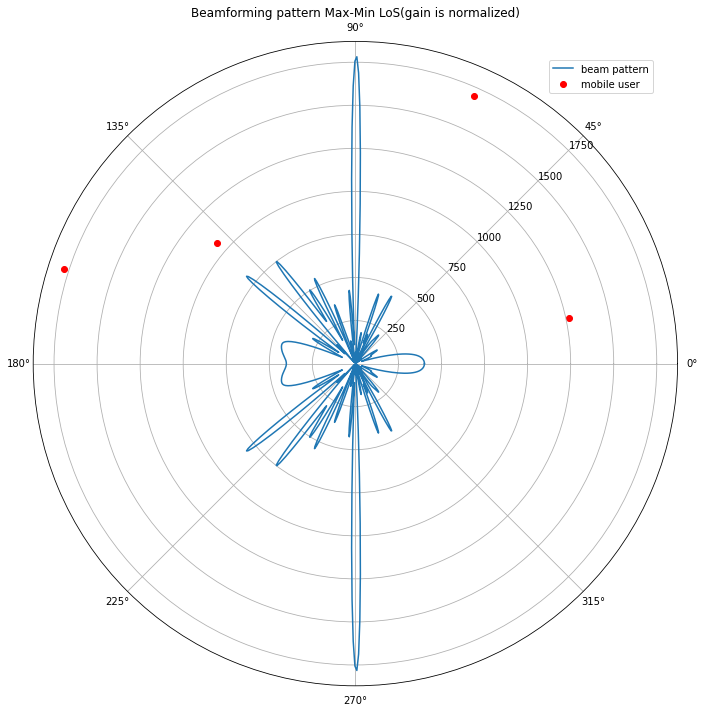

In [280]:
w = w_best_maxmin.ravel()
# Calculate gain and directive gain; plot on a polar chart.
phi, g = gain(w)
DdBi = get_directive_gain(g)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='polar', label="meters")
ax.plot(phi, g*np.max(distances)/np.max(g), label="beam pattern")
# ax.plot(phi, np.log(g)*np.max(distances)/np.log(np.max(g)), label="beam pattern")
ax.scatter(angles, distances, color="red", label="mobile user")
# ax.set_rticks([0, 50, 100, 200, 250])
ax.set_rlabel_position(45)
plt.title("Beamforming pattern Max-Min LoS(gain is normalized)")
plt.legend()
ax.legend(loc=(0.8,0.92))
plt.tight_layout()
plt.show()

In [181]:
# fig.savefig("fig5_maxmin_los_4user_32an.png")

## Plot both

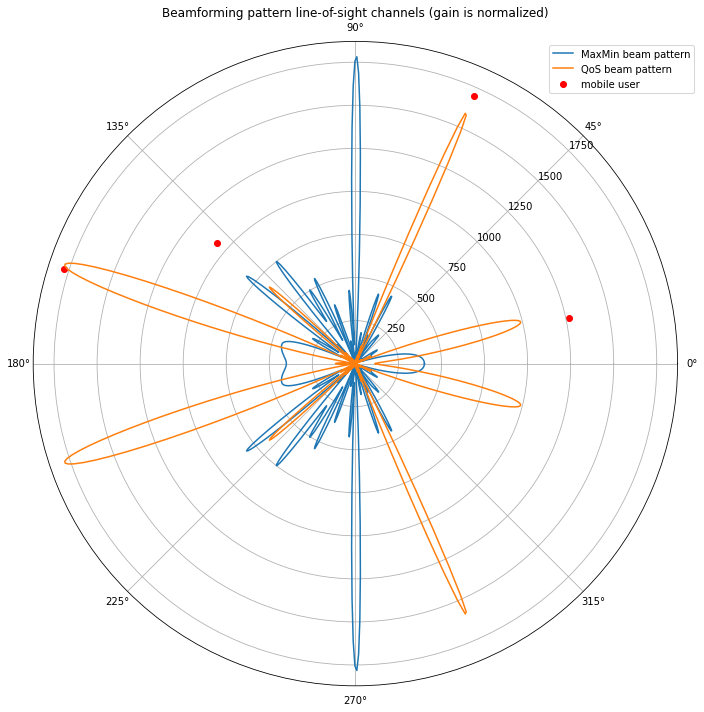

In [283]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='polar', label="meters")

# max min
w = w_best_maxmin.ravel()
phi, g = gain(w)
DdBi = get_directive_gain(g)
ax.plot(phi, g*np.max(distances)/np.max(g), label="MaxMin beam pattern")

# QoS
w = w_best_qos.ravel()
phi, g = gain(w)
DdBi = get_directive_gain(g)
ax.plot(phi, g*np.max(distances)/np.max(g), label="QoS beam pattern")

ax.scatter(angles, distances, color="red", label="mobile user")
# ax.set_rticks([0, 50, 100, 200, 250])
ax.set_rlabel_position(45)
plt.title("Beamforming pattern line-of-sight channels (gain is normalized)")
plt.legend()
ax.legend(loc=(0.8,0.92))
plt.tight_layout()
plt.show()

In [284]:
# fig.savefig("fig6_qos_maxmin_los_4user_32an.png")

## Generate Rayleigh channel

In [346]:
pl = get_path_loss_phase_diff(angles, distances, N, M)
h_array, h_array_norm_QoS, h_array_norm_MaxMin, H_array, H_array_norm_QoS, H_array_norm_MaxMin = generate_channels(N, M, pl=pl, rho_min_qos_sigma2=rho_min_qos_sigma2, sigma_i=sigma_i)

## QoS formulation

In [347]:
W = cp.Variable((N, N), hermitian=True)

# need to use cp.real since cp.trace will give imaginary part = 0j, which will break the code
constraints = [W >> 0]
constraints += [cp.real(cp.trace(cp.matmul(W, H_array_norm_QoS[i]))) >= 1 for i in range(M)]

prob = cp.Problem(cp.Minimize( cp.real(cp.trace(W))),
             constraints)
opt = prob.solve(solver="MOSEK", verbose=False)
W_opt = W.value

print("optimal objective value = ", opt)
# print("optimal beamforming vector = ", W_opt)

# recover svd
w_SVD   = recover_w_SVD(W_opt)
scale_factor_SVD = get_min_scale_factor(w_SVD, H_array_norm_QoS)
w_SVD *= scale_factor_SVD
ubpb_SVD = np.linalg.norm(w_SVD)**2/opt
print("SVD upper bound power boost = ", ubpb_SVD)
ubpb = []

for i in range(1000):
    # recover randomization
    w_randA = recover_w_randA(W_opt)
    w_randB = recover_w_randB(W_opt)
    w_randC = recover_w_randC(W_opt)

    scale_factor_randA = get_min_scale_factor(w_randA, h_array_norm_QoS)
    scale_factor_randB = get_min_scale_factor(w_randB, h_array_norm_QoS)
    scale_factor_randC = get_min_scale_factor(w_randC, h_array_norm_QoS)

    w_randA *= scale_factor_randA
    w_randB *= scale_factor_randB
    w_randC *= scale_factor_randC
    
    w_l = [w_SVD, w_randA, w_randB, w_randC]
    norm_l = [calc_norm2(w_SVD)**2, calc_norm2(w_randA)**2, calc_norm2(w_randB)**2, calc_norm2(w_randC)**2]

    w_min = w_l[np.argmin(norm_l)]
    ubpb.append(calc_norm2(w_min)**2/opt)
    
print("MC 1000 upper bound power boost = ", np.min(ubpb), "mean = ", np.mean(ubpb), "std = ", np.std(ubpb))

w_best = None
ubpb_best = np.inf

for i in range(30*N*M):
# for i in range(10000):
    # recover randomization
    w_randA = recover_w_randA(W_opt)
    w_randB = recover_w_randB(W_opt)
    w_randC = recover_w_randC(W_opt)

    scale_factor_randA = get_min_scale_factor(w_randA, h_array_norm_QoS)
    scale_factor_randB = get_min_scale_factor(w_randB, h_array_norm_QoS)
    scale_factor_randC = get_min_scale_factor(w_randC, h_array_norm_QoS)

    w_randA *= scale_factor_randA
    w_randB *= scale_factor_randB
    w_randC *= scale_factor_randC
    
    w_l = [w_SVD, w_randA, w_randB, w_randC]
    norm_l = [calc_norm2(w_SVD)**2, calc_norm2(w_randA)**2, calc_norm2(w_randB)**2, calc_norm2(w_randC)**2]

    w_min = w_l[np.argmin(norm_l)]
    ubpb.append(calc_norm2(w_min)**2/opt)
    
    if ubpb[-1] < ubpb_best:
        w_best = w_min
        ubpb_best = ubpb[-1]
w_best_qos = w_best
print("MC 30*N*M=", 30*N*M, "upper bound power boost = ", np.min(ubpb), "mean = ", np.mean(ubpb), "std = ", np.std(ubpb))

optimal objective value =  22829698914.69194
SVD upper bound power boost =  1.5518371990661386
MC 1000 upper bound power boost =  0.3381684668177007 mean =  1.2992208912720165 std =  0.2713717911267387
MC 30*N*M= 960 upper bound power boost =  0.3381684668177007 mean =  1.298617572191581 std =  0.27096021768593687


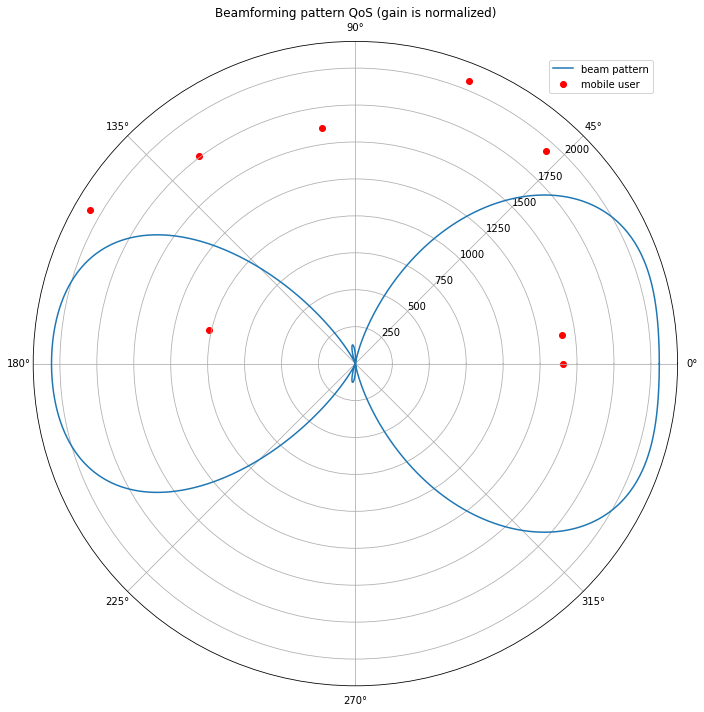

In [348]:
w = w_best_qos.ravel()
# Calculate gain and directive gain; plot on a polar chart.
phi, g = gain(w)
DdBi = get_directive_gain(g)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='polar', label="meters")
ax.plot(phi, g*np.max(distances)/np.max(g), label="beam pattern")
# ax.plot(phi, np.max(distances)*np.log10(g)/np.log10(np.max(g)), label="beam pattern")
ax.scatter(angles, distances, color="red", label="mobile user")
# ax.set_rticks([0, 50, 100, 200, 250])
ax.set_rlabel_position(45)
plt.title("Beamforming pattern QoS (gain is normalized)")
plt.legend()
ax.legend(loc=(0.8,0.92))
plt.tight_layout()

plt.show()

In [194]:
# fig.savefig("fig3_qos_4user_32an.png")

## MaxMin formulation

In [291]:
W = cp.Variable((N, N), hermitian=True)
t = cp.Variable(1)

constraints = [W >> 0]
constraints += [cp.real(cp.trace(W)) == 1] # power constraint
constraints += [cp.real(cp.trace(cp.matmul(W, H_array_norm_MaxMin[i]))) >= t for i in range(M)]

prob = cp.Problem(cp.Maximize(t),
             constraints)
opt = prob.solve(solver="MOSEK", verbose=False)
W_opt = W.value

print("optimal objective value = ", opt)
# print("optimal beamforming vector = ", W_opt)

w_best_maxmin = None
scal_min = np.inf
for i in tqdm.tqdm(range(30*N*M)):
    # recover randomization
    w_randA = recover_w_randA(W_opt)
    w_randB = recover_w_randB(W_opt)
    w_randC = recover_w_randC(W_opt)

    scale_factor_randA = calc_norm2(w_randA)
    scale_factor_randB = calc_norm2(w_randB)
    scale_factor_randC = calc_norm2(w_randC)

    w_randA /= scale_factor_randA
    w_randB /= scale_factor_randB
    w_randC /= scale_factor_randC

    w_l = [w_randA, w_randB, w_randC]
    scal = [scale_factor_randA, scale_factor_randB, scale_factor_randC]

    w_best_tmp = w_l[np.argmin(scal)]
    scal_min_tmp = np.min(scal)
    
    if scal_min_tmp < scal_min:
        w_best_maxmin = w_best_tmp
        scal_min = scal_min_tmp
    
print("min SNR = ", t.value[0])
print("min norm = ", scal_min)

optimal objective value =  2.8874517594308013e-09


100%|█████████████████████████████████████| 3840/3840 [00:03<00:00, 1110.24it/s]

min SNR =  2.8874517594308013e-09
min norm =  0.8948417230120005


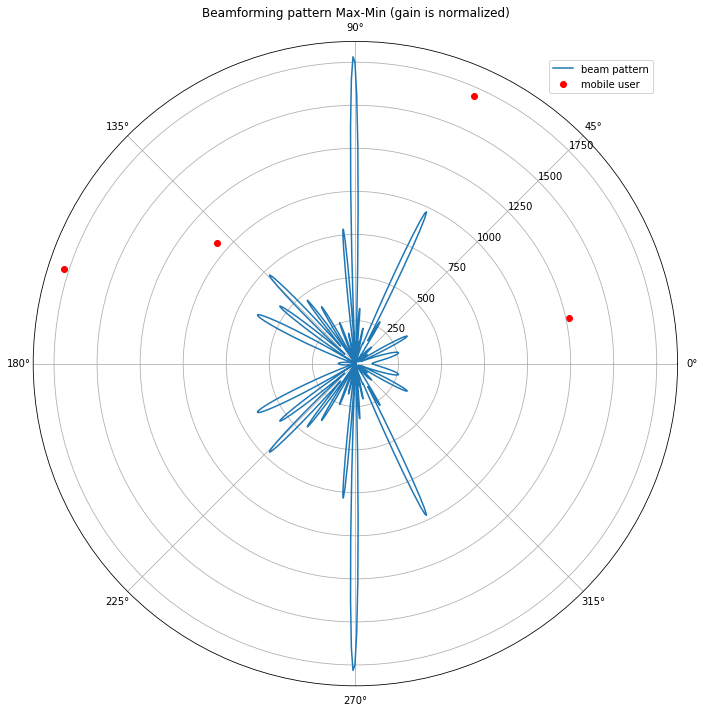

In [292]:
w = w_best_maxmin.ravel()
# Calculate gain and directive gain; plot on a polar chart.
phi, g = gain(w)
DdBi = get_directive_gain(g)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='polar', label="meters")
ax.plot(phi, g*np.max(distances)/np.max(g), label="beam pattern")
# ax.plot(phi, np.log(g)*np.max(distances)/np.log(np.max(g)), label="beam pattern")
ax.scatter(angles, distances, color="red", label="mobile user")
# ax.set_rticks([0, 50, 100, 200, 250])
ax.set_rlabel_position(45)
plt.title("Beamforming pattern Max-Min (gain is normalized)")
plt.legend()
ax.legend(loc=(0.8,0.92))
plt.tight_layout()
plt.show()

In [197]:
# fig.savefig("fig4_maxmin_4user_32an.png")

## Plot both

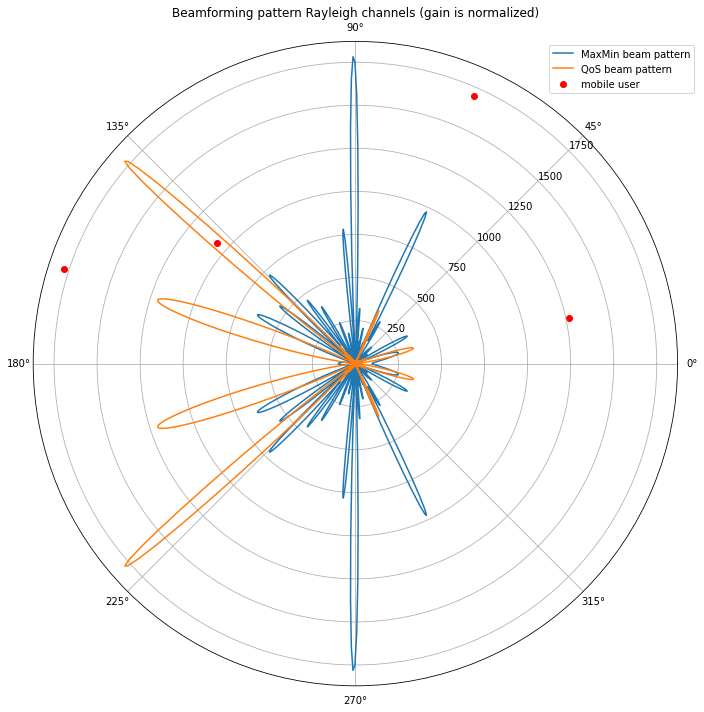

In [293]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='polar', label="meters")

# max min
w = w_best_maxmin.ravel()
phi, g = gain(w)
DdBi = get_directive_gain(g)
ax.plot(phi, g*np.max(distances)/np.max(g), label="MaxMin beam pattern")

# QoS
w = w_best_qos.ravel()
phi, g = gain(w)
DdBi = get_directive_gain(g)
ax.plot(phi, g*np.max(distances)/np.max(g), label="QoS beam pattern")

ax.scatter(angles, distances, color="red", label="mobile user")
# ax.set_rticks([0, 50, 100, 200, 250])
ax.set_rlabel_position(45)
plt.title("Beamforming pattern Rayleigh channels (gain is normalized)")
plt.legend()
ax.legend(loc=(0.8,0.92))
plt.tight_layout()
plt.show()

In [294]:
# fig.savefig("fig7_qos_maxmin_rayleigh_4user_32an.png")

## MaxMin average calc

In [378]:
N = 4 # number of transmit antennas
M = 16 # number of mobile users
# P = 1 # transmit power

In [379]:
angles = rand_angles(M)
distances = rand_distances(M)

In [380]:
def get_min_snr(w, h_array):
    min_snr = np.inf
    for h in h_array:
        snr = np.abs(np.dot(np.conjugate(h).T, w))**2
        min_snr = np.min([min_snr, snr])
    return min_snr
            

In [398]:
best_t = []
best_t_sdr = []

for k in tqdm.tqdm(range(1)):
    # regenerate channel, no path loss
    h_array, h_array_norm_QoS, h_array_norm_MaxMin, H_array, H_array_norm_QoS, H_array_norm_MaxMin = generate_channels(N, M, pl=None, rho_min_qos_sigma2=rho_min_qos_sigma2, sigma_i=sigma_i)
    
    W = cp.Variable((N, N), hermitian=True)
    t = cp.Variable(1)

    constraints = [W >> 0]
    constraints += [cp.real(cp.trace(W)) == 1] # power constraint
    constraints += [cp.real(cp.trace(cp.matmul(W, H_array_norm_MaxMin[i]))) >= t for i in range(M)]

    prob = cp.Problem(cp.Maximize(t),
                 constraints)
    opt = prob.solve(solver="MOSEK", verbose=False)
    W_opt = W.value
    
    best_t.append(t.value[0])

    t_sdr_tmp = np.inf
    for i in range(30*N*M):
        # recover randomization
        w_randA = recover_w_randA(W_opt)
        w_randB = recover_w_randB(W_opt)
        w_randC = recover_w_randC(W_opt)
        
#         scale_factor_randA = calc_norm2(w_randA)
#         scale_factor_randB = calc_norm2(w_randB)
#         scale_factor_randC = calc_norm2(w_randC)

#         w_randA /= scale_factor_randA
#         w_randB /= scale_factor_randB
#         w_randC /= scale_factor_randC

        t_sdr_tmp_tmp = np.min([get_min_snr(w_randA, h_array_norm_MaxMin),
                                get_min_snr(w_randB, h_array_norm_MaxMin),
                                get_min_snr(w_randC, h_array_norm_MaxMin)
                               ])
        t_sdr_tmp = np.min([t_sdr_tmp, t_sdr_tmp_tmp])
    best_t_sdr.append(t_sdr_tmp)

  0%|                                                     | 0/1 [00:00<?, ?it/s]/home/anvuong/miniconda3/envs/tf2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


In [392]:
recover_w_randA(W_opt)

array([[ 0.56275506+0.00664155j],
       [ 0.01380701+0.44300038j],
       [-0.26123835-0.4771509j ],
       [ 0.4275985 -0.08979834j]])

In [393]:
recover_w_randB(W_opt)

array([[-0.52468804+0.39928916j],
       [-0.3340566 -0.01710746j],
       [-0.0761934 +0.47783631j],
       [ 0.34524493+0.31631804j]])

In [394]:
np.linalg.norm(recover_w_randA(W_opt))

1.0000000084514682

In [395]:
np.linalg.norm(recover_w_randB(W_opt))

0.9999999973429082

In [396]:
np.linalg.norm(recover_w_randC(W_opt))

1.2164321730221095

In [401]:
for h in h_array_norm_MaxMin:
    snr = np.abs(np.dot(np.conjugate(h).T, w_randC))**2
    print(snr)

[[0.20656593]]
[[0.45234372]]
[[0.57329899]]
[[1.63586272]]
[[0.92166052]]
[[0.99195153]]
[[0.32704916]]
[[1.34930786]]
[[1.40064074]]
[[1.01700846]]
[[0.72458795]]
[[2.45545319]]
[[1.06196424]]
[[0.32333886]]
[[0.79332683]]
[[0.2809765]]


In [388]:
best_t_sdr

[9.951590978413928e-06,
 0.00010846426015417119,
 1.380507380605546e-06,
 6.432221776069362e-05,
 9.571522794623266e-06,
 2.487989670481983e-05,
 4.922896485476017e-06,
 3.625014072291275e-05,
 1.6542849508367705e-05,
 7.993035019652481e-06]

In [ ]:
w_randA